<a href="https://colab.research.google.com/github/grohan1130/lip-reader-cv/blob/main/lip_reader_cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install dependencies
!pip install tensorflow opencv-python matplotlib gdown imageio keras==2.13.1


In [ ]:
# Import necessary libraries
import os
import cv2
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import imageio
from typing import List

In [ ]:
import keras
print(keras.__version__)

2.13.1


In [ ]:
# Enable GPU support in TensorFlow
tf.config.list_physical_devices('GPU')
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

1. Data Loading Functions

In [ ]:
import gdown

In [ ]:

data_url = 'https://drive.google.com/uc?id=1GZ42ksPjkisUQJM6Jrt53h8Ew8WBkn6J'
output = 'data.zip'
gdown.download(data_url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1GZ42ksPjkisUQJM6Jrt53h8Ew8WBkn6J
From (redirected): https://drive.google.com/uc?id=1GZ42ksPjkisUQJM6Jrt53h8Ew8WBkn6J&confirm=t&uuid=09f1e75f-39d0-4e76-9de0-151fb4ff4adf
To: /content/data.zip
100%|██████████| 423M/423M [00:01<00:00, 256MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [ ]:
# verifying directory structure
!ls

checkpoints.zip  data  data.zip  drive	models	sample_data


In [ ]:
# Function to load video
def load_video(path: str) -> tf.Tensor:
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        if not ret:
            break
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236, 80:220, :])
    cap.release()
    frames = tf.stack(frames, axis=0)
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [ ]:
# vocabulary setup
vocabulary = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
vocabulary

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [ ]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocabulary, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), invert=True, oov_token=""
)
print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size: {char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size: 40)


In [ ]:
# Function to load alignments
def load_alignments(path: str) -> tf.Tensor:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Alignment file not found: {path}")
    with open(path, "r") as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if len(line) > 2 and line[2] != 'sil':
            tokens.extend([' ', line[2]])
    tokens = tf.strings.unicode_split(tokens, input_encoding="UTF-8")
    tokens = tf.reshape(tokens, (-1,))
    return char_to_num(tokens)[1:]

In [ ]:
# Function to load data (video + alignments)
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = os.path.basename(path).split('.')[0]
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')

    #print(f"Processing video: {video_path}")
    #print(f"Processing alignment: {alignment_path}")

    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    return frames, alignments


In [ ]:
# Test load_data function
test_path = './data/s1/bbal6n.mpg'
frames, alignments = load_data(tf.convert_to_tensor(test_path))

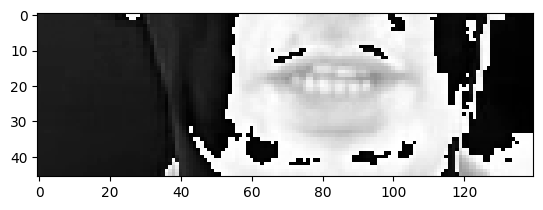

In [ ]:
# Display a sample frame
plt.imshow(frames[40].numpy().squeeze(), cmap='gray')
plt.show()

In [ ]:
# Decode alignments to text
alignment_text = tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])
print(f"Alignment text: {alignment_text.numpy().decode('utf-8')}")

Alignment text: bin blue at l six now


In [ ]:
# Mappable function for TensorFlow Dataset
def mappable_function(path: tf.Tensor):
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

2. Pipeline

In [ ]:
"""2. Pipeline"""

# Dataset pipeline
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)

# Adjust `padded_shapes` to match the model's input shape
data = data.padded_batch(
    2,  # Batch size
    padded_shapes=(
        [75, 46, 140, 1],  # Video frames: time_steps, height, width, channels
        [40]  # Alignments: max label length
    )
)
data = data.prefetch(tf.data.AUTOTUNE).cache()


In [ ]:
# Split dataset into train and test sets
train = data.take(450)
test = data.skip(450)

In [ ]:
# Test the pipeline
frames, alignments = next(iter(data.as_numpy_iterator()))
print("Sample pipeline output:")
print(f"Frames shape: {frames.shape}")
print(f"Alignments shape: {alignments.shape}")

Sample pipeline output:
Frames shape: (2, 75, 46, 140, 1)
Alignments shape: (2, 40)


In [ ]:
len(frames)


2

In [ ]:
sample = data.as_numpy_iterator()


In [ ]:
val = sample.next(); val[0]


array([[[[[1.5439053 ],
          [1.470386  ],
          [1.4336263 ],
          ...,
          [0.2940772 ],
          [0.2940772 ],
          [0.2940772 ]],

         [[1.580665  ],
          [1.470386  ],
          [1.3968667 ],
          ...,
          [0.2940772 ],
          [0.2940772 ],
          [0.2940772 ]],

         [[1.5071456 ],
          [1.5071456 ],
          [1.5071456 ],
          ...,
          [0.40435615],
          [0.3675965 ],
          [0.3675965 ]],

         ...,

         [[1.0660299 ],
          [1.0660299 ],
          [1.0292702 ],
          ...,
          [0.11027895],
          [0.11027895],
          [0.11027895]],

         [[1.0660299 ],
          [1.0660299 ],
          [1.0292702 ],
          ...,
          [0.0735193 ],
          [0.0735193 ],
          [0.0735193 ]],

         [[1.0660299 ],
          [1.0660299 ],
          [1.0292702 ],
          ...,
          [0.0735193 ],
          [0.0735193 ],
          [0.0735193 ]]],


        [[[1.4336

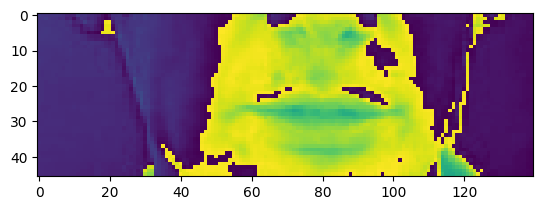

In [ ]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][0][35])

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay red by l three again'>

3. Neural Network Design

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation,
    Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
)
from tensorflow.keras.optimizers.legacy import Adam  # Use legacy optimizer
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler


In [ ]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [ ]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation_3 (Activation)   (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 75, 23, 70, 128)   0         
 g3D)                                                            
                                                                 
 conv3d_4 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_4 (Activation)   (None, 75, 23, 70, 256)   0         
                                                      

In [ ]:
5*17*75

6375

In [ ]:
!ls drive/MyDrive/

 Classes			        Notability
 CodingProjects			        Options-Graphs
'Colab Notebooks'		        Recreation
 Datasets			       'Resume Template.gdoc'
'ESE 419 Final Presentation.gslides'   'Screenshot 2024-08-12 at 11.54.56 PM.png'
'ESE 419 - Final Project Report.gdoc'   super-resolution.ipynb
'ESE 419 Term Project'		        tennis_ball_detector_training.ipynb
 ESRGAN.ipynb			       'Untitled document.gdoc'
'Hi Shishi.gdoc'		       'Untitled form (1).gform'
 IMG_6465.jpeg			       'Untitled form.gform'
'Leetcode problems.gsheet'	       'Untitled form (Responses).gsheet'
'MNIST Digits Classification.ipynb'     Weights


In [ ]:
yhat = model.predict(val[0])

1/1 [==============================] - 11s 11s/step


In [ ]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss'>

In [ ]:
model.input_shape


(None, 75, 46, 140, 1)

In [ ]:
model.output_shape


(None, 75, 41)

4. Setting Up Operations and Training

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    # Set input and label lengths for each batch
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    # Compute CTC loss
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(
            yhat, input_length=tf.fill([len(yhat)], tf.shape(yhat)[1]), greedy=True
        )[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~' * 100)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)


In [ ]:
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join('models', 'checkpoint.weights.h5'),
    monitor='loss',
    save_weights_only=True
)

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = ProduceExample(test)

In [ ]:
print("GPUs available:", tf.config.list_physical_devices('GPU'))


GPUs available: []


In [ ]:
# Train the model
model.fit(
    train,
    validation_data=test,
    epochs=10,
    callbacks=[checkpoint_callback, schedule_callback, example_callback]
)


Epoch 1/10


KeyboardInterrupt: 

# 5. Predictions/Inference

In [ ]:
import gdown
weights_url = 'https://drive.google.com/uc?id=1KrIRzef1kA-ykWoVQ4PespDyGtzdrd5G'
output = 'checkpoints.zip'
gdown.download(weights_url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (original): https://drive.google.com/uc?id=1KrIRzef1kA-ykWoVQ4PespDyGtzdrd5G
From (redirected): https://drive.google.com/uc?id=1KrIRzef1kA-ykWoVQ4PespDyGtzdrd5G&confirm=t&uuid=1e7905bf-3702-4156-b34a-503ee6a1de2e
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:00<00:00, 255MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [ ]:
import os

file_path = "/content/models/checkpoint"

if os.path.isfile(file_path):
    print(f"File exists at: {file_path}")
else:
    print(f"File does not exist at: {file_path}")


File exists at: /content/models/checkpoint


In [ ]:
import os
file_path = '/content/models/checkpoint'
file_extension = os.path.splitext(file_path)[1]  # Gets '.txt'
print(f"File extension: {file_extension}")

File extension: 


In [ ]:
model.load_weights('models/checkpoint')


In [ ]:
test_data = test.as_numpy_iterator()


In [ ]:
sample = test_data.next()


In [ ]:
yhat = model.predict(sample[0])


1/1 [==============================] - 15s 15s/step


In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay green in s zero please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay blue by y four please'>]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red in m one again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin white at t four please'>]

In [ ]:
sample = load_data(tf.convert_to_tensor('/content/data/s1/bras9a.mpg'))


In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))


1/1 [==============================] - 4s 4s/step


In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()


In [ ]:

print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red in m one again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin white at t four please'>]